# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (400135, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (400135,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print 'next_h error: ', rel_error(expected_next_h, next_h)
print 'next_c error: ', rel_error(expected_next_c, next_c)

next_h error:  5.70541319671e-09
next_c error:  5.81431230888e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-8` or less.

In [4]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print 'dx error: ', rel_error(dx_num, dx)
print 'dh error: ', rel_error(dh_num, dh)
print 'dc error: ', rel_error(dc_num, dc)
print 'dWx error: ', rel_error(dWx_num, dWx)
print 'dWh error: ', rel_error(dWh_num, dWh)
print 'db error: ', rel_error(db_num, db)

dx error:  7.8398679483e-10
dh error:  2.60555566575e-09
dc error:  1.69461050389e-05
dWx error:  5.79628647556e-09
dWh error:  6.42963194329e-09
db error:  2.61875747345e-09


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print 'h error: ', rel_error(expected_h, h)

h error:  8.61053745211e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-8` or less.

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print 'dx error: ', rel_error(dx_num, dx)
print 'dh0 error: ', rel_error(dx_num, dx)
print 'dWx error: ', rel_error(dx_num, dx)
print 'dWh error: ', rel_error(dx_num, dx)
print 'db error: ', rel_error(dx_num, dx)

dx error:  1.96386615948e-09
dh0 error:  1.96386615948e-09
dWx error:  1.96386615948e-09
dWh error:  1.96386615948e-09
db error:  1.96386615948e-09


# LSTM captioning model
Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.iteritems():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print 'loss: ', loss
print 'expected loss: ', expected_loss
print 'difference: ', abs(loss - expected_loss)

loss:  9.82445935443
expected loss:  9.82445935443
difference:  2.26130225656e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN above.

(Iteration 1 / 100) loss: 76.392254
(Iteration 11 / 100) loss: 42.271518
(Iteration 21 / 100) loss: 24.076143
(Iteration 31 / 100) loss: 12.016555
(Iteration 41 / 100) loss: 6.215670
(Iteration 51 / 100) loss: 2.192126
(Iteration 61 / 100) loss: 1.567881
(Iteration 71 / 100) loss: 0.413747
(Iteration 81 / 100) loss: 0.344400
(Iteration 91 / 100) loss: 0.182965


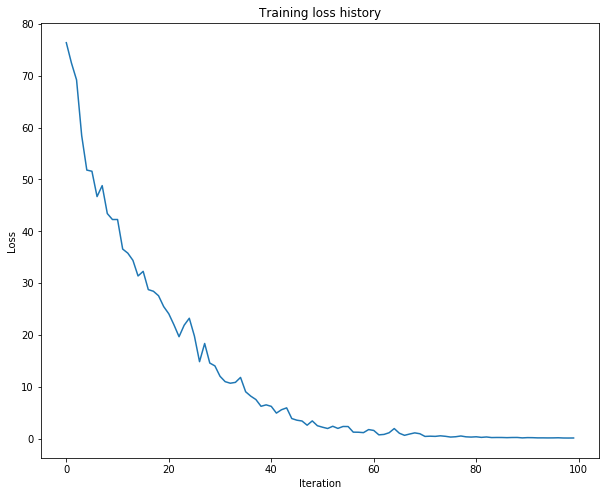

In [8]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

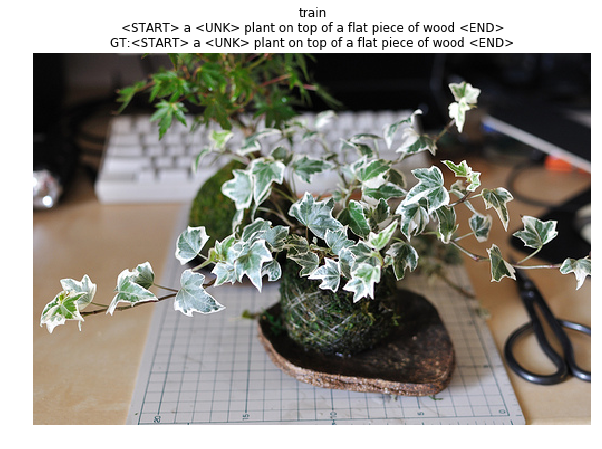

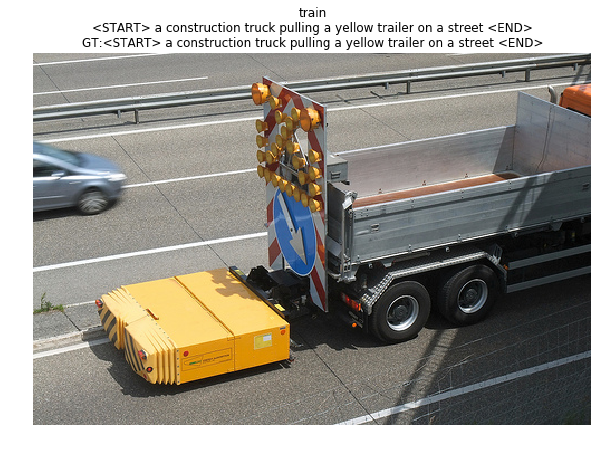

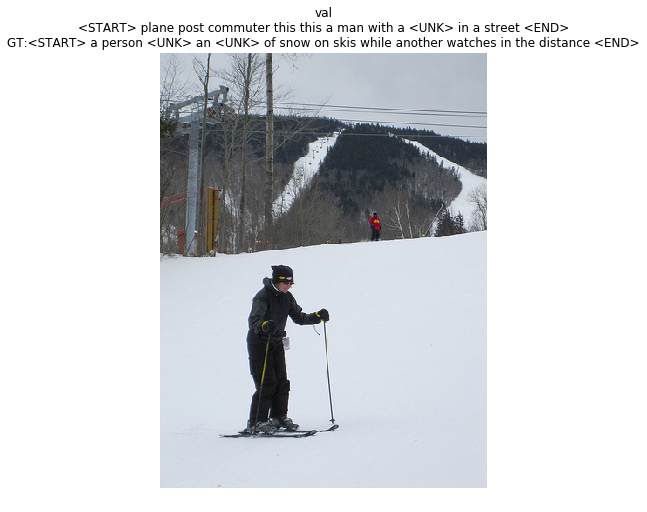

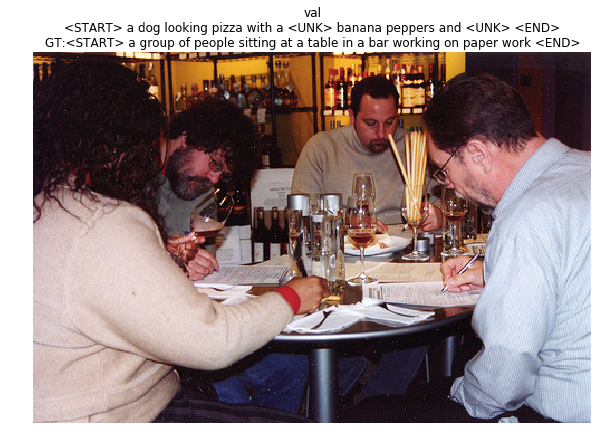

In [9]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = small_lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validatation set that are better than random.

Don't spend too much time on this part; we don't have any explicit accuracy thresholds you need to meet.

In [3]:
data = load_coco_data(pca_features=True)

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, data,
           update_rule='adam',
           num_epochs=3,
           batch_size=128,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

lstm_solver.train()

# Plot the training losses
plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()


(Iteration 1 / 9378) loss: 76.878448
(Iteration 11 / 9378) loss: 55.404114
(Iteration 21 / 9378) loss: 49.665423
(Iteration 31 / 9378) loss: 48.464857
(Iteration 41 / 9378) loss: 42.207529
(Iteration 51 / 9378) loss: 39.218002
(Iteration 61 / 9378) loss: 38.431391
(Iteration 71 / 9378) loss: 37.383053


KeyboardInterrupt: 

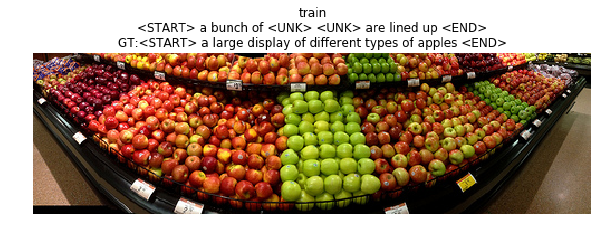

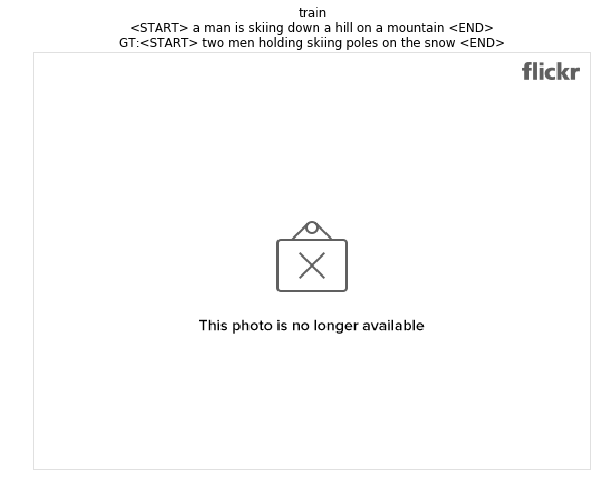

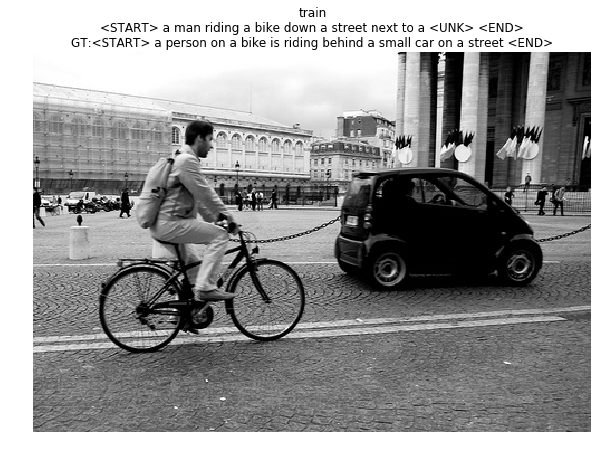

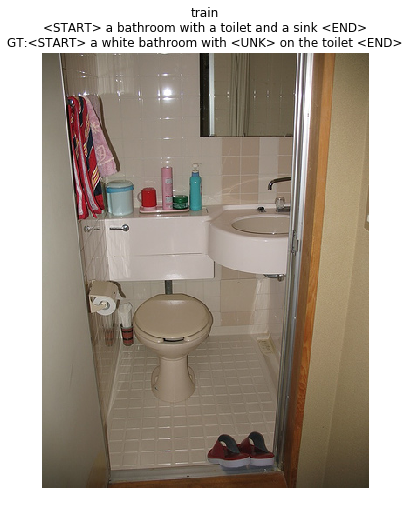

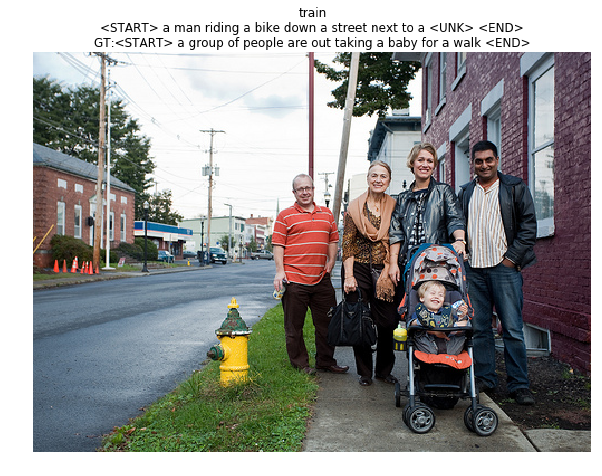

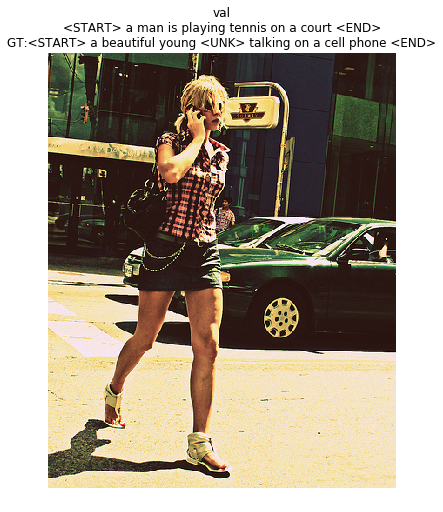

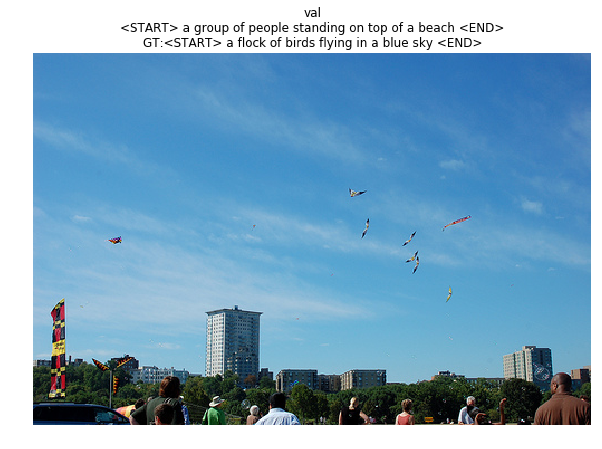

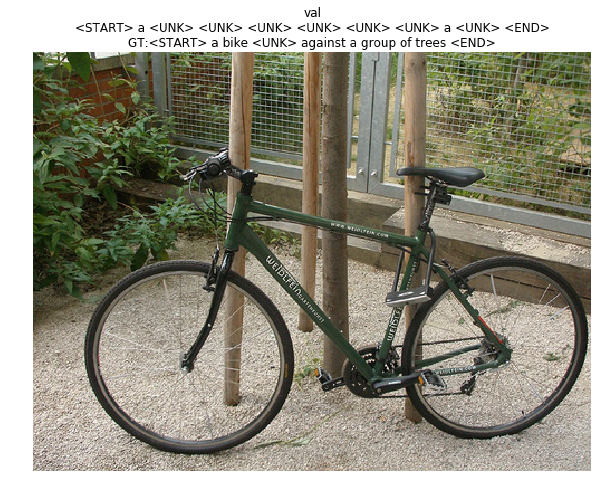

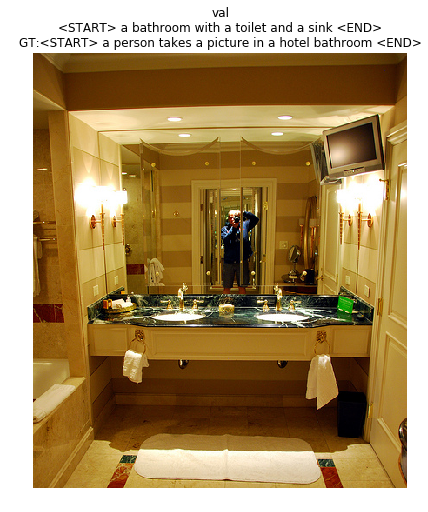

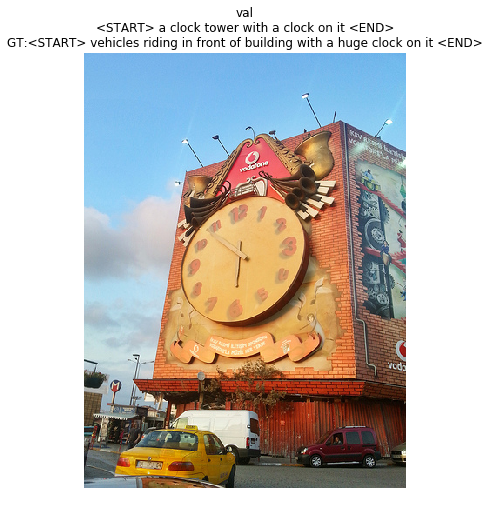

In [33]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=5)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# SRU: step backward

In [2]:
from cs231n.sru  import *

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_c = np.random.randn(N, H)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)

next_h, next_c, cache = sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)


fx = lambda x: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fc = lambda prev_c: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fW = lambda W: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fWf = lambda Wf: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fWr = lambda Wr: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fWh = lambda Wh: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fbf = lambda bf: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]
fbr = lambda br: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[0]

fx_c = lambda x: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fc_c = lambda prev_c: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fW_c = lambda W: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fWf_c = lambda Wf: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fWr_c = lambda Wr: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fWh_c = lambda Wh: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fbf_c = lambda bf: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]
fbr_c = lambda br: sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dc_num = num_grad(fc, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dW_num = num_grad(fW, W, dnext_h) + num_grad(fW_c, W, dnext_c)
dWf_num = num_grad(fWf, Wf, dnext_h) + num_grad(fWf_c, Wf, dnext_c)
dWr_num = num_grad(fWr, Wr, dnext_h) + num_grad(fWr_c, Wr, dnext_c)
dWh_num = num_grad(fWh, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
dbf_num = num_grad(fbf, bf, dnext_h) + num_grad(fbf_c, bf, dnext_c)
dbr_num = num_grad(fbr, br, dnext_h) + num_grad(fbr_c, br, dnext_c)

dx, dpc, dW, dWf, dWr, dWh, dbf, dbr = sru_step_backward(dnext_h, dnext_c, cache)
print 'dx error: ', rel_error(dx_num, dx)
print 'dc error: ', rel_error(dc_num, dpc)
print 'dW error: ', rel_error(dW_num, dW)
print 'dWf error: ', rel_error(dWf_num, dWf)
print 'dWr error: ', rel_error(dWr_num, dWr)
print 'dWh error: ', rel_error(dWh_num, dWh)
print 'dbf error: ', rel_error(dbf_num, dbf)
print 'dbr error: ', rel_error(dbr_num, dbr)

dx error:  4.34276466522e-11
dc error:  3.11706633087e-11
dW error:  1.41085858651e-10
dWf error:  5.36962525854e-10
dWr error:  1.23053844828e-09
dWh error:  3.37649896286e-10
dbf error:  1.71089762758e-10
dbr error:  9.50196894745e-11


# SRU: backward

In [3]:
from cs231n.sru  import *

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)

out, cache = sru_forward(x, W, Wf, Wr, Wh, bf, br)

dout = np.random.randn(*out.shape)

dx, dW, dWf, dWr, dWh, dbf, dbr = sru_backward(dout, cache)

fx = lambda x: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]
fW = lambda W: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]
fWf = lambda Wf: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]
fWr = lambda Wr: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]
fWh = lambda Wh: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]
fbf = lambda bf: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]
fbr = lambda br: sru_forward(x, W, Wf, Wr, Wh, bf, br)[0]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx, x, dout)
dW_num = num_grad(fW, W, dout)
dWf_num = num_grad(fWf, Wf, dout)
dWr_num = num_grad(fWr, Wr, dout)
dWh_num = num_grad(fWh, Wh, dout)
dbf_num = num_grad(fbf, bf, dout)
dbr_num = num_grad(fbr, br, dout)

print 'dx error: ', rel_error(dx_num, dx)
print 'dc error: ', rel_error(dc_num, dpc)
print 'dW error: ', rel_error(dW_num, dW)
print 'dWf error: ', rel_error(dWf_num, dWf)
print 'dWr error: ', rel_error(dWr_num, dWr)
print 'dWh error: ', rel_error(dWh_num, dWh)
print 'dbf error: ', rel_error(dbf_num, dbf)
print 'dbr error: ', rel_error(dbr_num, dbr)

dx error:  1.05099088907e-09
dc error:  3.11706633087e-11
dW error:  6.22608660304e-11
dWf error:  1.18305911974e-10
dWr error:  9.44914424198e-10
dWh error:  9.69668720405e-11
dbf error:  4.49995938354e-10
dbr error:  2.158322902e-10


# SRU vs LSTM

In [4]:
from cs231n.sru  import *
from time import time

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)

MAX = 10000
start = time()
for i in range(MAX):
    out, cache = sru_forward(x, W, Wf, Wr, Wh, bf, br)
end = time()
print 'SRU: ', (end-start)

from cs231n.rnn_layers import lstm_forward, lstm_backward

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

start = time()
for i in range(MAX):
    out, cache = lstm_forward(x, h0, Wx, Wh, b)
end = time()
print 'LSTM: ', (end-start)


SRU:  4.74809002876
LSTM:  8.09695792198


# SRU step: compact weight matrix

In [5]:
from cs231n.sru  import *

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_c = np.random.randn(N, H)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)

W_ALL = np.hstack((W, Wf, Wr, Wh))

next_h, next_c, cache = sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)
next_h_fast, next_c_fast, cache_fast = sru_step_forward_fast(x, prev_c, W_ALL, bf, br)
print 'next_h fast relative error:', rel_error(next_h, next_h_fast)
print 'next_c fast relative error:', rel_error(next_c, next_c_fast)

MAX = 100000
start = time()
for i in range(MAX):
    next_h, next_c, cache = sru_step_forward(x, prev_c, W, Wf, Wr, Wh, bf, br)
end = time()
print 'time 1:', end-start

start = time()
for i in range(MAX):
    next_h_fast, next_c_fast, cache_fast = sru_step_forward_fast(x, prev_c, W_ALL, bf, br)
end = time()
print 'time 2:', end-start

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)
dx, dpc, dW, dWf, dWr, dWh, dbf, dbr = sru_step_backward(dnext_h, dnext_c, cache)
dxfast, dpcfast, dWfast, dbffast, dbrfast = sru_step_backward_fast(dnext_h, dnext_c, cache_fast)
print rel_error(dx, dxfast)
print rel_error(dpc, dpcfast)
print rel_error(dWfast, np.hstack((dW, dWf, dWr, dWh)))
print rel_error(dbf, dbffast)
print rel_error(dbr, dbrfast)

next_h fast relative error: 0.0
next_c fast relative error: 0.0
time 1: 4.45426607132
time 2: 5.98226499557
4.7430476074e-16
0.0
0.0
0.0
0.0


# SRU compact forward

In [22]:
from cs231n.sru  import *
from time import time

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)


MAX = 1000
start = time()
for i in range(MAX):
    out, cache = sru_forward(x, W, Wf, Wr, Wh, bf, br)
end = time()
print 'SRU: ', (end-start)


W_ALL = np.hstack((W, Wf, Wr, Wh))
start = time()
for i in range(MAX):
    out_fast, cache_fast = sru_forward_fast(x, W_ALL, bf, br)
end = time()
print 'SRU compact: ', (end-start)

print (out - out_fast) < 1e-10
print rel_error(out, out_fast)

SRU:  0.629642009735
SRU compact:  0.588633060455
[[[ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]]

 [[ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]
  [ True  True  True  True  True  True]]]
8.10474094075e-16


# SRU compact backward

In [27]:
from cs231n.sru  import *

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)

W_ALL = np.hstack((W, Wf, Wr, Wh))

out, cache = sru_forward(x, W, Wf, Wr, Wh, bf, br)
out_fast, cache_fast = sru_forward_fast(x, W_ALL, bf, br)
print rel_error(out, out_fast)

dout = np.random.randn(*out.shape)

dx, dW, dWf, dWr, dWh, dbf, dbr = sru_backward(dout, cache)
dxfast, dWfast, dbffast, dbrfast = sru_backward_fast(dout, cache_fast)

print rel_error(dx, dxfast)
print rel_error(dWfast, np.hstack((dW, dWf, dWr, dWh)))
print rel_error(dbf, dbffast)
print rel_error(dbr, dbrfast)

2.24025946383e-15
2.23948836217e-15
1.8441606813e-15
1.1358296018e-15
4.86100876167e-16


# SRU compact backward advance

In [37]:
from cs231n.sru  import *

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
W = np.random.randn(D, H)
Wf = np.random.randn(D, H)
Wr = np.random.randn(D, H)
Wh = np.random.randn(D, H)
bf = np.random.randn(H)
br = np.random.randn(H)

W_ALL = np.hstack((W, Wf, Wr, Wh))

out, cache = sru_forward(x, W, Wf, Wr, Wh, bf, br)
out_fast, cache_fast = sru_forward_fast(x, W_ALL, bf, br)
print rel_error(out, out_fast)

dout = np.random.randn(*out.shape)

dx, dW, dWf, dWr, dWh, dbf, dbr = sru_backward(dout, cache)
dxfast, dWfast, dbffast, dbrfast = sru_backward_fast(dout, cache_fast)
dxfasta, dWfasta, dbffasta, dbrfasta = sru_backward_fast_advance(dout, cache_fast)

print rel_error(dx, dxfast)
print rel_error(dWfast, np.hstack((dW, dWf, dWr, dWh)))
print rel_error(dbf, dbffast)
print rel_error(dbr, dbrfast)

print rel_error(dx, dxfasta)
print rel_error(dWfasta, np.hstack((dW, dWf, dWr, dWh)))
print rel_error(dbf, dbffasta)
print rel_error(dbr, dbrfasta)

3.87908289401e-15
2.273891033e-13
4.21091975812e-15
3.70935704287e-16
4.1355613401e-16
2.273891033e-13
4.21091975812e-15
3.70935704287e-16
4.1355613401e-16


# numpy SRU and Kaldi SRU debug

In [68]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=8)

N, D, H, T = 2, 3, 3, 3

x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
W = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
bf = np.linspace(0.2, 0.7, num=H)
br = np.linspace(0.2, 0.7, num=H)

print 'x', np.reshape(np.transpose(x, (1, 0, 2)), (-1, x.shape[-1]))

out_fast, cache_fast = sru_forward_fast(x, W, bf, br)
print 'x', x
print 'W.T', W.T
print 'bf', bf
print 'br', br
print 'out', out_fast
print 'transpose out\n',  np.reshape(np.transpose(out_fast, (1, 0, 2)), (-1, out_fast.shape[-1]))


dout = np.linspace(-0.6, 0.6, num=N*T*H).reshape(N, T, H)
dxfasta, dWfasta, dbffasta, dbrfasta = sru_backward_fast_advance(dout, cache_fast)
print 'dout transpose\n', np.reshape(np.transpose(dout, (1, 0, 2)), (-1, dout.shape[-1]))
print 'dxfasta transpose\n', np.reshape(np.transpose(dxfasta, (1, 0, 2)), (-1, dxfasta.shape[-1]))

x [[-0.4        -0.34117647 -0.28235294]
 [ 0.12941176  0.18823529  0.24705882]
 [-0.22352941 -0.16470588 -0.10588235]
 [ 0.30588235  0.36470588  0.42352941]
 [-0.04705882  0.01176471  0.07058824]
 [ 0.48235294  0.54117647  0.6       ]]
x [[[-0.4        -0.34117647 -0.28235294]
  [-0.22352941 -0.16470588 -0.10588235]
  [-0.04705882  0.01176471  0.07058824]]

 [[ 0.12941176  0.18823529  0.24705882]
  [ 0.30588235  0.36470588  0.42352941]
  [ 0.48235294  0.54117647  0.6       ]]]
W.T [[-0.2         0.17714286  0.55428571]
 [-0.16857143  0.20857143  0.58571429]
 [-0.13714286  0.24        0.61714286]
 [-0.10571429  0.27142857  0.64857143]
 [-0.07428571  0.30285714  0.68      ]
 [-0.04285714  0.33428571  0.71142857]
 [-0.01142857  0.36571429  0.74285714]
 [ 0.02        0.39714286  0.77428571]
 [ 0.05142857  0.42857143  0.80571429]
 [ 0.08285714  0.46        0.83714286]
 [ 0.11428571  0.49142857  0.86857143]
 [ 0.14571429  0.52285714  0.9       ]]
bf [ 0.2   0.45  0.7 ]
br [ 0.2   0.45  0.7 